# Procesamiento de datos para BS-Solctra

Confeccionado a partir de los códigos brindados en el repositorio de PlasmaTEC (https://gitlab.com/josees/plasmatec/)

Una vez se obtienen los pares ordenados de las líneas de fuerza del campo magnético a partir de BS-Solctra, es necesario construir los mapas de Poincaré, interpretado como las superficies de flujo magnético del plasma y con ello la forma del plasma.

BS-Solctra da como resultado varios archivos de texto que presentan todas las líneas de fuerzas de campo magnético, es decir tanto las confinantes como las que no confinan en dirección toroidal. Debe separarse aquellas líneas de campo confinantes.


In [1]:
#Paquetes importantes

import sys
import os #manejo de archivos
import pandas as pd
from pathlib import Path, PurePath #manejo de rutas y archivos
import numpy as np #manejo de matrices
from numpy import linalg # norma
from scipy import misc
from scipy import ndimage
import matplotlib #gráficos 
#matplotlib.use('Qt5Agg')
from mpl_toolkits.mplot3d import Axes3D #gráficos en 3D
import matplotlib.pyplot as plt
from PIL import Image
from scipy import special
from scipy.interpolate import griddata
import plotly #Plot 3D
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import plotly.express as px # Plot 2D dispersión
from plotly.subplots import make_subplots #subplots
from datetime import datetime #tiempo de ejecución

# Solo para Brave - graficos en el jupyter
%matplotlib inline 
#Gráficos interactivos
#%matplotlib widget

#Graficación
#plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
import locale #líbreria para el formato
locale.setlocale(locale.LC_ALL, "es_CR.utf8")


#Latex y coma como separador decimal
plt.rcParams['text.usetex'] = True #latex
#plt.rc('text', usetex=False)
plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
#se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{} \usepackage{ziffer} \usepackage{xcolor} \usepackage{mathpazo} \usepackage{calrsfs} \usepackage{siunitx} \sisetup{output-decimal-marker = {,}}  ') 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
 })
#math-rm=\mathsf,

## Mapas de Poincaré

Es necesario identificar un ángulo toroidal (coordenada azimutal $\phi$) indicado y extraer todo los datos de R y Z.Se almacenan los datos de cada anillo de tal forma que se tiene una matriz con 7 entradas almacenadas en una matriz para cada anillo y otra matriz que almacena todos los anillos

In [34]:
def Plasma_Poincare_data(directorio, angulo):
    #Cargar archivos
    archivos_LF_cil = os.listdir(directorio)  #Se obtiene la lista de archivos de trayectoria
    datos_cil_ang_total =[]
    for iArchivo in archivos_LF_cil:
        ruta_archivo = PurePath(Path(directorio), Path(iArchivo))
        # Cargar archivo de datos
        try:
            datos = np.loadtxt(ruta_archivo, delimiter=' ', skiprows=1) #para superficies de flujo
            #print('Archivo: {} cargado con éxito'.format(iArchivo))
        except:
            #print('Excepción: {}. Archivo: {}'.format(sys.exc_info()[0], iArchivo))
            continue
            
        angulo_tor = np.radians(angulo) # ángulo en radianes
        
        # Se identifican los índices que no tienen el ángulo deseado
        # obtener puntos en los casos de 360 y 0
        if np.isclose(angulo_tor, 0.000, rtol=.1, atol=.1) == True :
            indice_a_remover = np.where( (np.isclose(datos[:,1], angulo_tor, rtol=.001, atol=.001) == False) & (np.isclose(datos[:,1], angulo_tor + 2*np.pi, rtol=.001, atol=.001) == False))
            
        elif np.isclose(angulo_tor, 2*np.pi, rtol=.1, atol=.1) == True :
            indice_a_remover = np.where( (np.isclose(datos[:,1], angulo_tor, rtol=.001, atol=.001) == False) & (np.isclose(datos[:,1], angulo_tor-2*np.pi, rtol=.001, atol=.001) == False))
            
        else :    
            indice_a_remover = np.where(np.isclose(datos[:,1], angulo_tor, rtol=.001, atol=.001) == False)
        
        
        # Se remueven los índices que no tienen el ángulo deseado
        #datos_cil_ang = np.delete(datos_1, indice_a_remover,0)
        datos_cil_ang = np.delete(datos, indice_a_remover,0)
        
        # Se cambia a lista para usar la función append
        datos_cil_ang = datos_cil_ang.tolist()
        # Se utiliza append para almacenar en la lista
        datos_cil_ang_total.append(datos_cil_ang[:])
        # Se convierte cada lista dentro de la lista a numpy array
        datos_filtrados=np.array([np.array(xi) for xi in datos_cil_ang_total], dtype = object)
    return datos_filtrados
    

In [35]:
start_time = datetime.now()
#datos_finales_0 = Plasma_Poincare_data('Dir_BS', 0.000)
datos_finales_1 = Plasma_Poincare_data('Dir_BS', 15.000)
datos_finales_2 = Plasma_Poincare_data('Dir_BS', 315.000)
datos_finales_3 = Plasma_Poincare_data('Dir_BS', 120.000)
datos_finales_4 = Plasma_Poincare_data('Dir_BS', 73.000)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:07:10.019196


In [32]:
def Plasma_Poincare_extract_data(datos_filtrados): #Extraer cada superficie
    nArchivos = len(datos_filtrados)
    datos_R = []
    datos_Z = []
    datos_Bx = []
    datos_By = []
    datos_Bz = []
    datos_cita = []
    for i in range(0,nArchivos-14,1):
    #for i in range(nArchivos): #todos los datos del corte
    #for i in [x for x in range(nArchivos) if x != 3]: #se salta el archivo 3 para el input de campo magnético
    #for i in range(nArchivos):
            #if i == 22 or i == 3:
                #continue
            #print(i)
    #for i in range(41,42): #selecciona la superficie
            nSuperficies, _ = datos_filtrados[i].shape
            for j in range(nSuperficies): #forman la cantidad de puntos de la superficie
                cita_numpy = np.arctan2(datos_filtrados[i][j][2], (datos_filtrados[i][j][0] - 0.2477)) #filtro
                datos_cita.append(cita_numpy.tolist())
                datos_R.append(datos_filtrados[i][j][0].tolist())
                datos_Z.append(datos_filtrados[i][j][2].tolist()) 
                datos_Bx.append(datos_filtrados[i][j][4].tolist())
                datos_By.append(datos_filtrados[i][j][5].tolist())
                datos_Bz.append(datos_filtrados[i][j][6].tolist())
    datos_R = np.asarray(datos_R)
    datos_Z = np.asarray(datos_Z)
    datos_Bx = np.asarray(datos_Bx)
    datos_By = np.asarray(datos_By)
    datos_Bz = np.asarray(datos_Bz)
    datos_cita = np.asarray(datos_cita)
    datos_phi = np.radians(90.0) * np.ones(len(datos_R))
    
    #Gráfico
    plt.plot(datos_R, np.abs(datos_By), 'o')
    plt.xlabel('R(m)')
    plt.ylabel('B(T)')
    C = np.c_[datos_R, datos_Z, datos_Bx, datos_By, datos_Bz]
    
   
    #r,z,B_x,B_y,B_z
    #np.savetxt('r+z+B_mag_componentes.txt',  C , header='R (m), z (m), B_x (T), B_y (T), B_z (T)', 
               #delimiter=' ', fmt='%f') #quitar notación científica
    

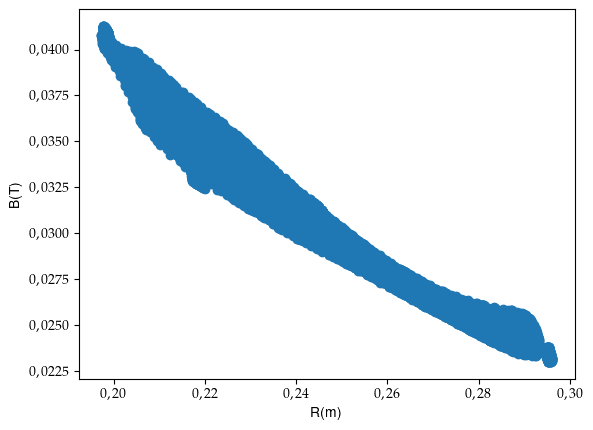

In [37]:
#print(datos_finales_1)
Plasma_Poincare_extract_data(datos_finales_2)

In [75]:
def Plasma_Poincare_Plot_Matplotlib(datos_filtrados, m ,n):
#Gráfico con plotly
    nArchivos = len(datos_filtrados)
    datos_RZ = []
    datos_R = []
    datos_Z = []
    datos_RZ_total = []
    for i in range(0,nArchivos-m,n): #selecciona la superficie
            nSuperficies, _ = datos_filtrados[i].shape
            for j in range(nSuperficies): #forman la cantidad de puntos de la superficie
                datos_R.append(datos_filtrados[i][j][0].tolist())
                datos_Z.append(datos_filtrados[i][j][2].tolist()) 
    datos_R = np.asarray(datos_R)
    datos_Z = np.asarray(datos_Z)
    print(np.max(nArchivos))
    #ordenar datos https://numpy.org/doc/stable/reference/generated/numpy.lexsort.html
    ind = np.lexsort((datos_R,datos_Z))
    R_ordenado = [datos_R[i] for i in ind]
    Z_ordenado = [datos_Z[i] for i in ind]
    
    #Gráfico
    #Cámara del scr-1
    r = 0.18/2
    R0 = 0.2477
    theta = np.linspace(0, 2*np.pi, 60)
    x1 = r*np.cos(theta) + R0
    y1 = r*np.sin(theta)
    eje = np.average(datos_R)
    
    #Superficie de flujo magnético
    fig = plt.figure()  
    ax = fig.add_subplot(111)
    
    #Gráficos
    ax.plot(datos_R, datos_Z,'o', markersize=0.3, color = '#b28ace', zorder=1) #color plasma SCR-1
    ax.plot(x1, y1)
    ax.set_ylabel(r'$Z$ $\left( \si{\metre} \right)$', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_xlabel(r'$R$ $\left( \si{\metre} \right)$',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    
    ax.tick_params(axis='both', labelsize=14, width=1.5)
    ax.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10

    plt.setp(ax.spines.values(), linewidth=1.5)
    #ax.set_aspect(1 / ax.get_data_ratio())
    plt.gca().set_aspect("equal")
    
    
    plt.savefig('Posiciones_sonda.png',  dpi=300, bbox_inches='tight')
    
    plt.show()
    
     
    
    #return datos_R, datos_Z

60


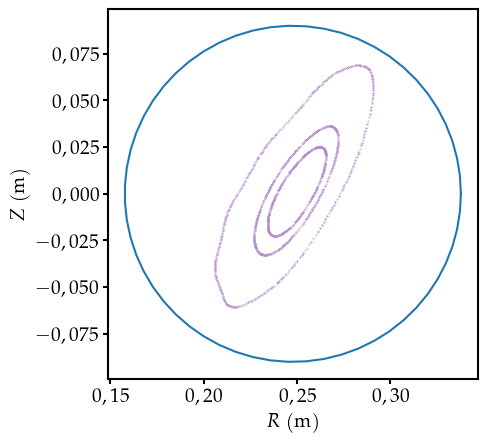

In [87]:
#Plasma_Poincare_Plot_Matplotlib(datos_finales_0, 10, 1)
Plasma_Poincare_Plot_Matplotlib(datos_finales_3, 4, 20)
#Plasma_Poincare_Plot_Matplotlib(datos_finales_1, 1, 1)
#Plasma_Poincare_Plot_Matplotlib(datos_finales_3, 1, 1)